In [ ]:
import numpy as np
import matplotlib as mpl
mpl.use('Agg')

import geopandas as gpd
import cartopy.crs as crs
from cartopy.feature import NaturalEarthFeature
import cartopy.io.shapereader as shpreader
import matplotlib.ticker as mticker

from matplotlib import gridspec
import time 
import scipy.stats as stats
import tensorflow as tf
import tensorflow_probability as tfp

from demo import *
from demo_backup import *

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Myriad Pro'
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 600

coastline = gpd.read_file('/home/mizu_home/xp53/nas_home/coastlines-split-SGregion/lines.shp')
mask = np.loadtxt('mask.txt')

In [ ]:
# DATA PREPARATION
# the station-based rainfall data is already organized in a N by P matrix
rain_obs = np.loadtxt('data/sta_monthly.csv')

# the simulated rainfall data is reshaped to a 2d matrix of size N by (W x L)
rain_sim_flatten = np.loadtxt('data/wrf_monthly.csv')
rain_sim = rain_sim_flatten.reshape(rain_sim_flatten.shape[0], 120, 160)

# sim_sel constains a P by 4 matrix
# the first two columns are the row and column indices of grids corresponding to the stations
# the last two columns are the lons and lats of grids corresponding to the stations
sim_sel = np.loadtxt('data/wrf_loc.csv')
sim_idx = sim_sel[:, :2].astype(int)

# select simulated rainfall at stations
wrf_sta = np.array([rain_sim[:, i, j] for (i, j) in sim_idx]).T

# lats and lons of all grids are stored in a 2d matrix of 2 by (W x L)
# the first row is lons and the second row is lats
longlat = np.loadtxt('data/lonlat.txt')
lons = longlat[0, :].reshape(120, 160)
lats = longlat[1, :].reshape(120, 160)

# read station lons (3rd column) and lats (4th column)
sta_loc = np.genfromtxt('data/sta_lookup_new.csv', delimiter=',')[:, 2:]

# read wrf simulated rainfall forced by cmip6 future climate
cmip_rain_f = np.loadtxt('data/wrf_monthly_cmip.txt')[-40:, :]
cmip_rain0 = cmip_rain_f.reshape(cmip_rain_f.shape[0], 12, 120, 160)
cmip_rain = np.zeros(cmip_rain0.shape)
cmip_rain[:, 0:6, :, :] = cmip_rain0[:, 6:12, :, :]
cmip_rain[:, 6:12, :, :] = cmip_rain0[:, 0:6, :, :]


In [ ]:
tmp1 = gp_interpolator(P = sim_idx.shape[0])
tmp1.read_rainfall(obs = rain_obs[0::12, :], sim = wrf_sta[0::12, :])
tmp1.sn_converge()
tmp0 = gp(target_season=[1])
tmp0.sn_converge()

In [ ]:
tmp0.sn

In [ ]:
tmp1 = gp_interpolator(P = sim_idx.shape[0] - 1)

In [ ]:
for i in range(1, 13):
    tmp0 = gp(target_season=[i])
    tmp0.sn_converge()

    tmp1.read_rainfall(obs = rain_obs[(i-1)::12, :], sim = wrf_sta[(i-1)::12, :])
    tmp1.sn_converge()

    diff = 100 * np.abs(np.mean(tmp0.sn - tmp1.sn) / np.mean(tmp0.sn))
    print('difference between two methods: ', diff)

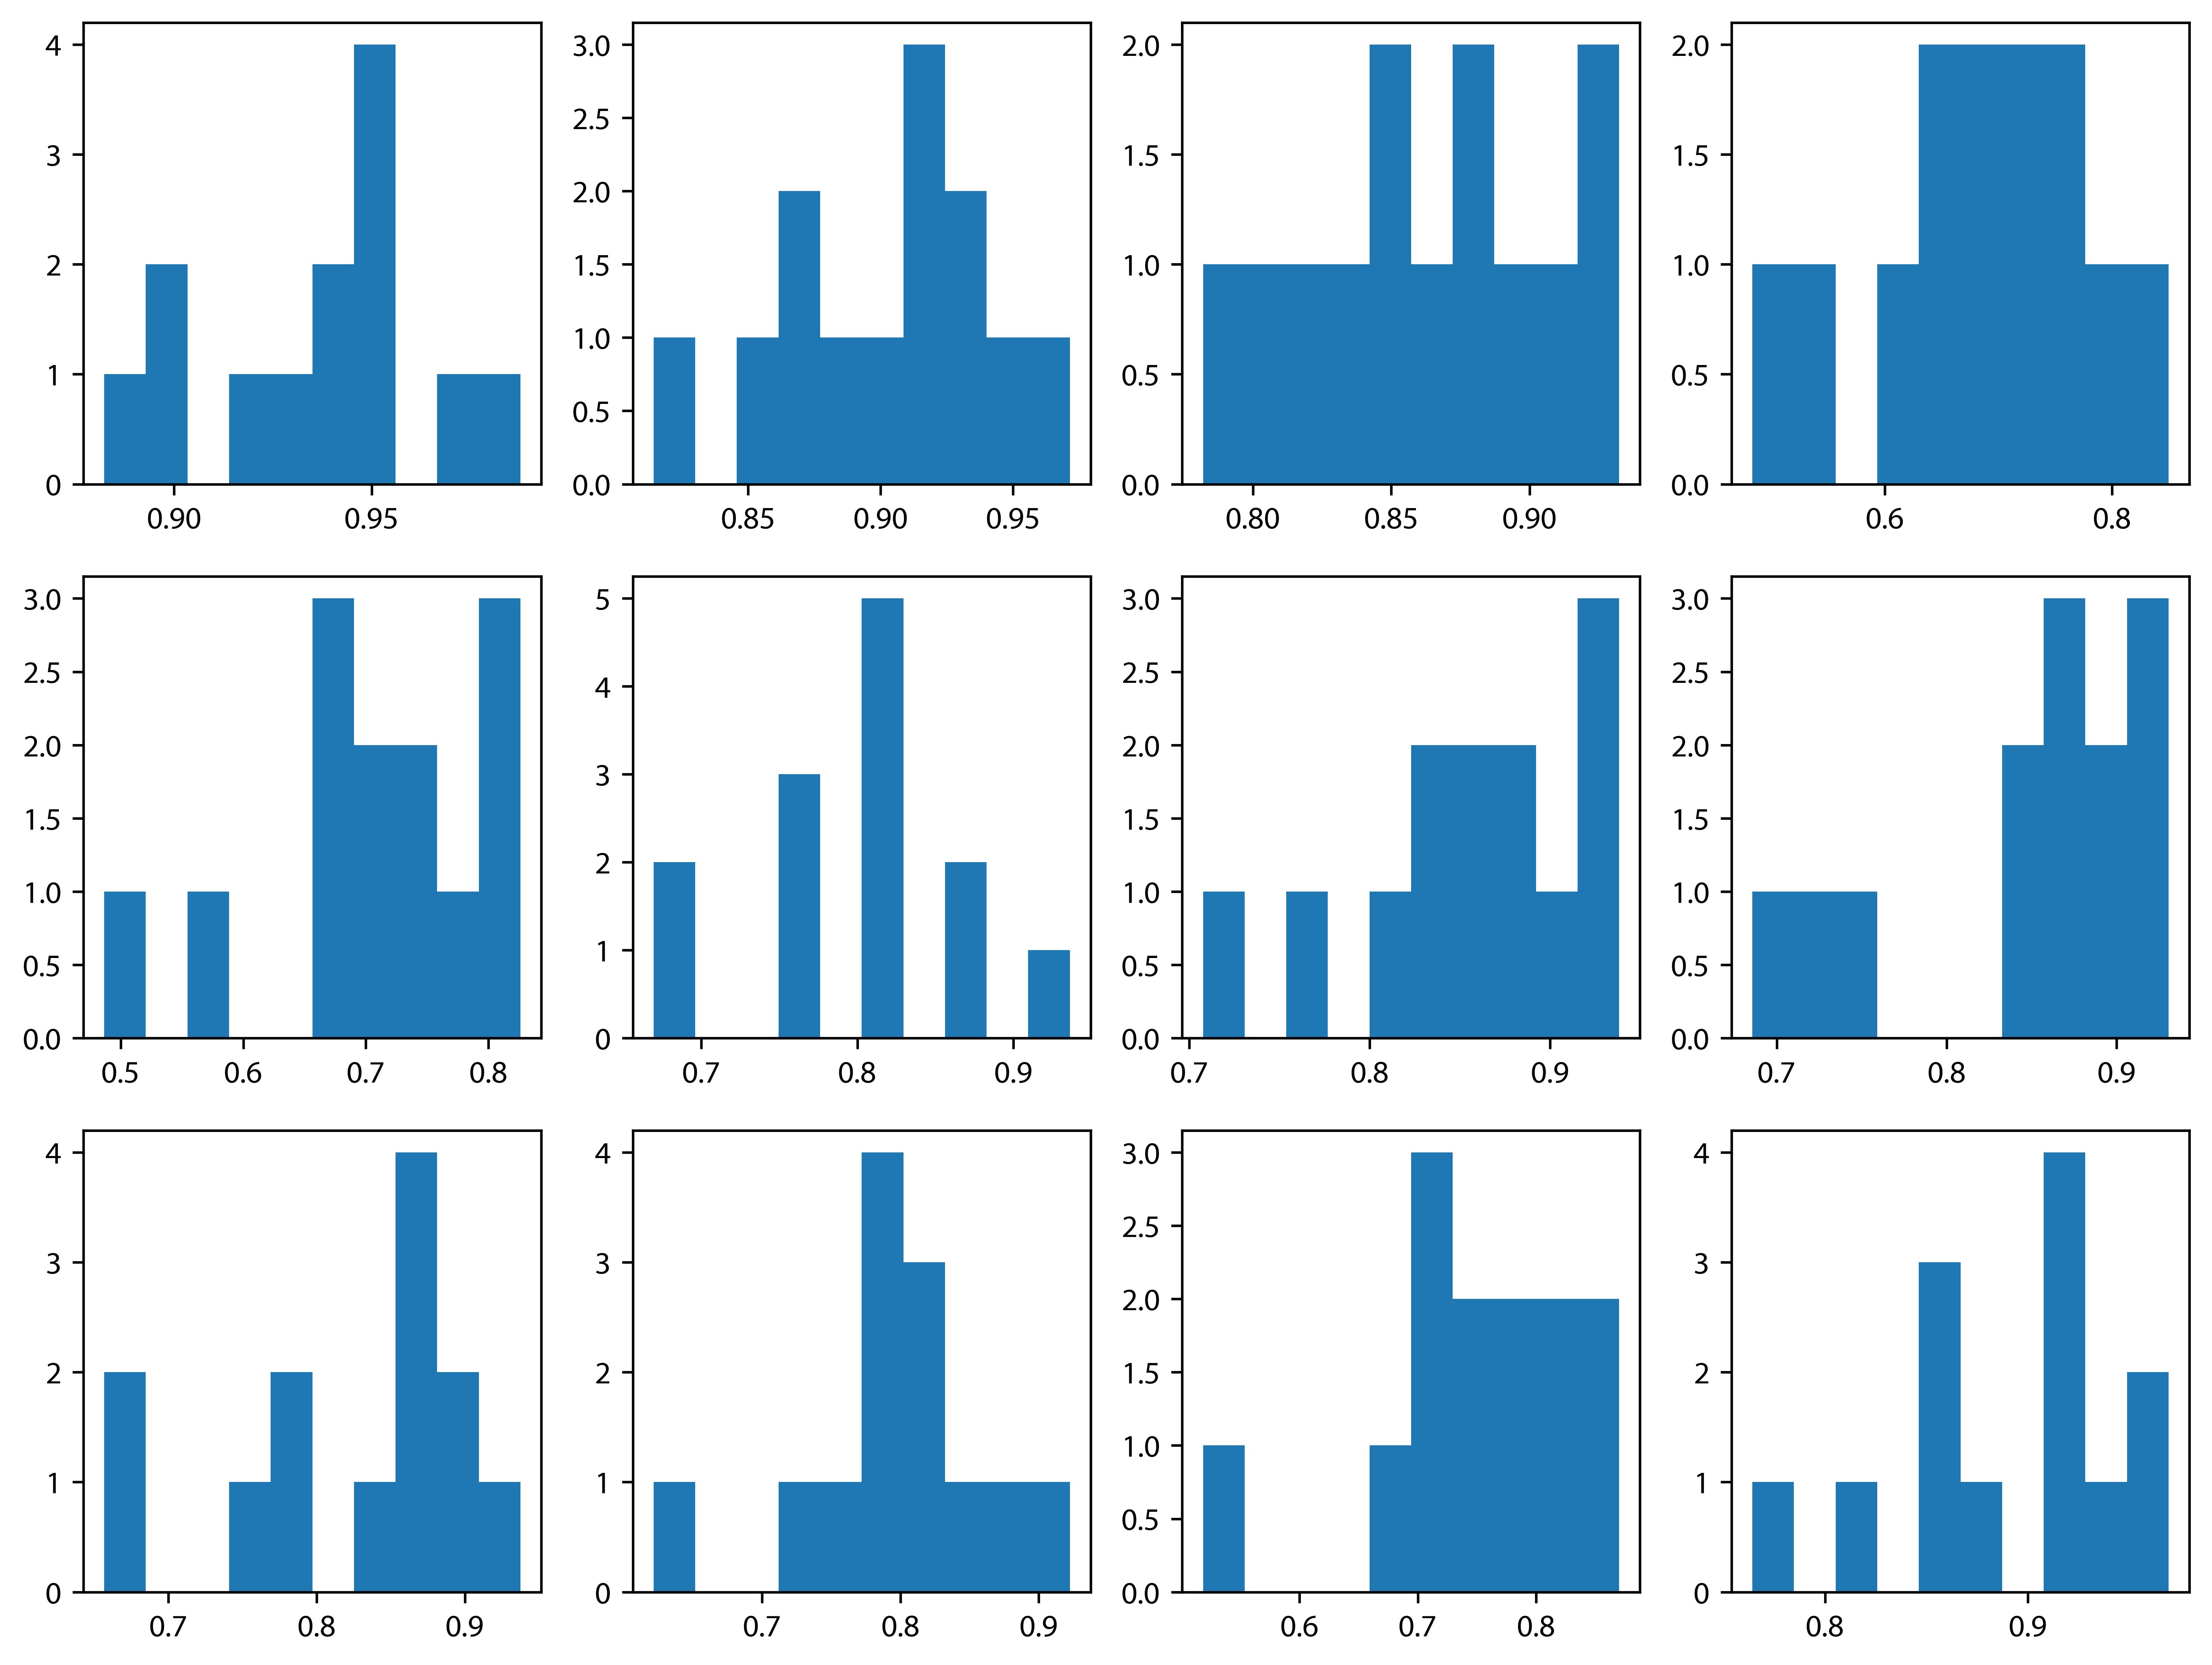

In [23]:
tmp1 = gp_interpolator(P = sim_idx.shape[0] - 1)
fig, ax = plt.subplots(nrows = 3, ncols = 4, figsize = (12, 9))
for i in range(12):
    xx_obs = rain_obs[i::12, :]
    xx_sim = wrf_sta[i::12, :]
    kge0 = []
    kge1 = []
    for j in range(tmp1.p_):
        txx_obs = np.delete(xx_obs, j, axis = 1)
        txx_sim = np.delete(xx_sim, j, axis = 1)
        tmp1.read_rainfall(obs = txx_obs, sim = txx_sim)
        tmp1.sn_converge()
        yy_sim = xx_sim[:, j][:, None]
        yy_obs = xx_obs[:, j][:, None]
        yy_fit, _ = tmp1.predict(yy_sim)
        kge0.append(kge(yy_obs, yy_sim))
        kge1.append(kge(yy_obs, yy_fit))
    
    ridx, cidx = i // 4, i % 4
    ax[ridx, cidx].hist(cc)
    

In [ ]:
fig, ax = plt.subplots(nrows = 3, ncols = 4, figsize = (12, 9))
plt.show()